In [ ]:
!pip install -U -q tensorflow==2.9.0

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

In [1]:
!nvidia-smi


Sun Aug 13 16:39:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/MyDrive/Fish dataset'
!unrar x Fish-Pak.rar

In [ ]:
pip install split-folders


In [ ]:
import splitfolders
import os
path = "/content/drive/MyDrive/Fish dataset/Fish-Pak"
print(os.listdir(path))

In [ ]:
import splitfolders

input_folder = '/content/drive/MyDrive/Fish dataset/Fish-Pak'

splitfolders.ratio(input_folder, output="/content/drive/MyDrive/Fish dataset/Fish_Splitted",
                   seed=42, ratio=(.7, .0, .3),
                   group_prefix=None)

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


--2023-08-13 16:39:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-13 16:39:48 (67.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
train_dir = "/content/drive/MyDrive/Fish dataset/Fish_Splitted/train/"
test_dir = "/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/"

In [4]:
walk_through_dir("/content/drive/MyDrive/Fish dataset/Fish_Splitted/")


There are 3 directories and 0 images in '/content/drive/MyDrive/Fish dataset/Fish_Splitted/'.
There are 6 directories and 0 images in '/content/drive/MyDrive/Fish dataset/Fish_Splitted/train'.
There are 0 directories and 39 images in '/content/drive/MyDrive/Fish dataset/Fish_Splitted/train/Catla'.
There are 0 directories and 91 images in '/content/drive/MyDrive/Fish dataset/Fish_Splitted/train/Cyprinus carpio'.
There are 0 directories and 25 images in '/content/drive/MyDrive/Fish dataset/Fish_Splitted/train/Grass Carp'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Fish dataset/Fish_Splitted/train/Mori'.
There are 0 directories and 80 images in '/content/drive/MyDrive/Fish dataset/Fish_Splitted/train/Rohu'.
There are 0 directories and 82 images in '/content/drive/MyDrive/Fish dataset/Fish_Splitted/train/Silver'.
There are 6 directories and 0 images in '/content/drive/MyDrive/Fish dataset/Fish_Splitted/val'.
There are 0 directories and 0 images in '/content/drive/MyD

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 417 files belonging to 6 classes.
Found 182 files belonging to 6 classes.


In [6]:
# Create checkpoint callback to save model for later use
checkpoint_path = "/content/drive/MyDrive/Fish dataset/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)


In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")


In [8]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [9]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable

In [10]:
 #Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes = model.fit(train_data,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
14/14 [==============================] - ETA: 0s - loss: 1.6209 - accuracy: 0.3717

14/14 [==============================] - 172s 3s/step - loss: 1.6209 - accuracy: 0.3717
Epoch 2/5
14/14 [==============================] - ETA: 0s - loss: 1.2142 - accuracy: 0.6091

14/14 [==============================] - 72s 2s/step - loss: 1.2142 - accuracy: 0.6091
Epoch 3/5
14/14 [==============================] - ETA: 0s - loss: 1.0115 - accuracy: 0.7194

14/14 [==============================] - 69s 2s/step - loss: 1.0115 - accuracy: 0.7194
Epoch 4/5
14/14 [==============================] - ETA: 0s - loss: 0.8896 - accuracy: 0.7482

14/14 [==============================] - 68s 2s/step - loss: 0.8896 - accuracy: 0.7482
Epoch 5/5
14/14 [==============================] - ETA: 0s - loss: 0.7703 - accuracy: 0.7818

14/14 [==============================] - 66s 2s/step - loss: 0.7703 - accuracy: 0.7818


In [11]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

6/6 [==============================] - 75s 12s/step - loss: 0.9606 - accuracy: 0.6923


[0.9606261849403381, 0.692307710647583]

In [12]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [13]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [14]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [15]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [16]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes.epoch[-1]) # start from previous last epoch


Epoch 5/10
14/14 [==============================] - 79s 2s/step - loss: 0.6885 - accuracy: 0.8153
Epoch 6/10
14/14 [==============================] - 67s 2s/step - loss: 0.5683 - accuracy: 0.8585
Epoch 7/10
14/14 [==============================] - 67s 2s/step - loss: 0.4968 - accuracy: 0.8729
Epoch 8/10
14/14 [==============================] - 68s 2s/step - loss: 0.4370 - accuracy: 0.8801
Epoch 9/10
14/14 [==============================] - 67s 2s/step - loss: 0.3952 - accuracy: 0.9065
Epoch 10/10
14/14 [==============================] - 65s 2s/step - loss: 0.3239 - accuracy: 0.9424


In [17]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_fine_tune = model.evaluate(test_data)
results_all_classes_fine_tune

6/6 [==============================] - 31s 5s/step - loss: 0.5114 - accuracy: 0.8791


[0.5114368200302124, 0.8791208863258362]

In [18]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

6/6 [==============================] - 27s 5s/step - loss: 0.5114 - accuracy: 0.8791


(0.5114368200302124, 0.8791208863258362)

In [19]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

6/6 [==============================] - 29s 5s/step


In [20]:
# How many predictions are there?
len(pred_probs)

182

In [21]:
# What's the shape of our predictions?
pred_probs.shape

(182, 6)

In [22]:
# How do they look?
pred_probs[:10]

array([[0.46479908, 0.054266  , 0.02508862, 0.00318642, 0.4504888 ,
        0.00217102],
       [0.47501016, 0.02678107, 0.02436947, 0.00608116, 0.46478546,
        0.00297264],
       [0.11718141, 0.18734667, 0.05098654, 0.02123166, 0.61610425,
        0.00714952],
       [0.08687864, 0.19285546, 0.0483734 , 0.01722812, 0.65115327,
        0.00351104],
       [0.06591958, 0.18930706, 0.05160013, 0.02668182, 0.66135085,
        0.00514054],
       [0.14748274, 0.294532  , 0.03858902, 0.0371952 , 0.4647933 ,
        0.01740769],
       [0.6018595 , 0.05682338, 0.04493129, 0.00853102, 0.2474638 ,
        0.04039099],
       [0.7394085 , 0.02190088, 0.04050461, 0.01607913, 0.15852006,
        0.02358682],
       [0.6908973 , 0.01540696, 0.16048649, 0.01545767, 0.11498704,
        0.00276464],
       [0.2947404 , 0.12531222, 0.16645354, 0.16074467, 0.14948863,
        0.10326052]], dtype=float32)

In [23]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 6
What prediction probability sample 0 looks like:
 [0.46479908 0.054266   0.02508862 0.00318642 0.4504888  0.00217102]
The class with the highest predicted probability by the model for sample 0: 0


In [24]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 4, 4, 4, 4, 0, 0, 0, 0])

In [25]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [26]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

182

In [27]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.8791208791208791

In [28]:
# Does the evaluate method compare to the Scikit-Learn measured accuracy?
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: 7.204957075401808e-09


In [29]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
from helper_functions import make_confusion_matrix

In [30]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.
    # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [31]:
# Get the class names
class_names = test_data.class_names
class_names[:10]

['Catla', 'Cyprinus carpio', 'Grass Carp', 'Mori', 'Rohu', 'Silver']

In [32]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80        17
           1       0.93      0.95      0.94        40
           2       0.71      0.45      0.56        11
           3       0.78      1.00      0.88        43
           4       0.87      0.77      0.82        35
           5       1.00      0.97      0.99        36

    accuracy                           0.88       182
   macro avg       0.87      0.81      0.83       182
weighted avg       0.88      0.88      0.87       182



In [34]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.9230769230769231,
  'recall': 0.7058823529411765,
  'f1-score': 0.8000000000000002,
  'support': 17},
 '1': {'precision': 0.926829268292683,
  'recall': 0.95,
  'f1-score': 0.9382716049382716,
  'support': 40},
 '2': {'precision': 0.7142857142857143,
  'recall': 0.45454545454545453,
  'f1-score': 0.5555555555555556,
  'support': 11},
 '3': {'precision': 0.7818181818181819,
  'recall': 1.0,
  'f1-score': 0.8775510204081634,
  'support': 43},
 '4': {'precision': 0.8709677419354839,
  'recall': 0.7714285714285715,
  'f1-score': 0.8181818181818182,
  'support': 35},
 '5': {'precision': 1.0,
  'recall': 0.9722222222222222,
  'f1-score': 0.9859154929577464,
  'support': 36},
 'accuracy': 0.8791208791208791,
 'macro avg': {'precision': 0.8694963049014977,
  'recall': 0.8090131001895707,
  'f1-score': 0.8292459153402593,
  'support': 182},
 'weighted avg': {'precision': 0.8831026047641849,
  'recall': 0.8791208791208791,
  'f1-score': 0.874208739390305,
  'support': 182}}

In [35]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'Catla': 0.8000000000000002,
 'Cyprinus carpio': 0.9382716049382716,
 'Grass Carp': 0.5555555555555556,
 'Mori': 0.8775510204081634,
 'Rohu': 0.8181818181818182,
 'Silver': 0.9859154929577464}

In [36]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
5           Silver  0.985915
1  Cyprinus carpio  0.938272
3             Mori  0.877551
4             Rohu  0.818182
0            Catla  0.800000

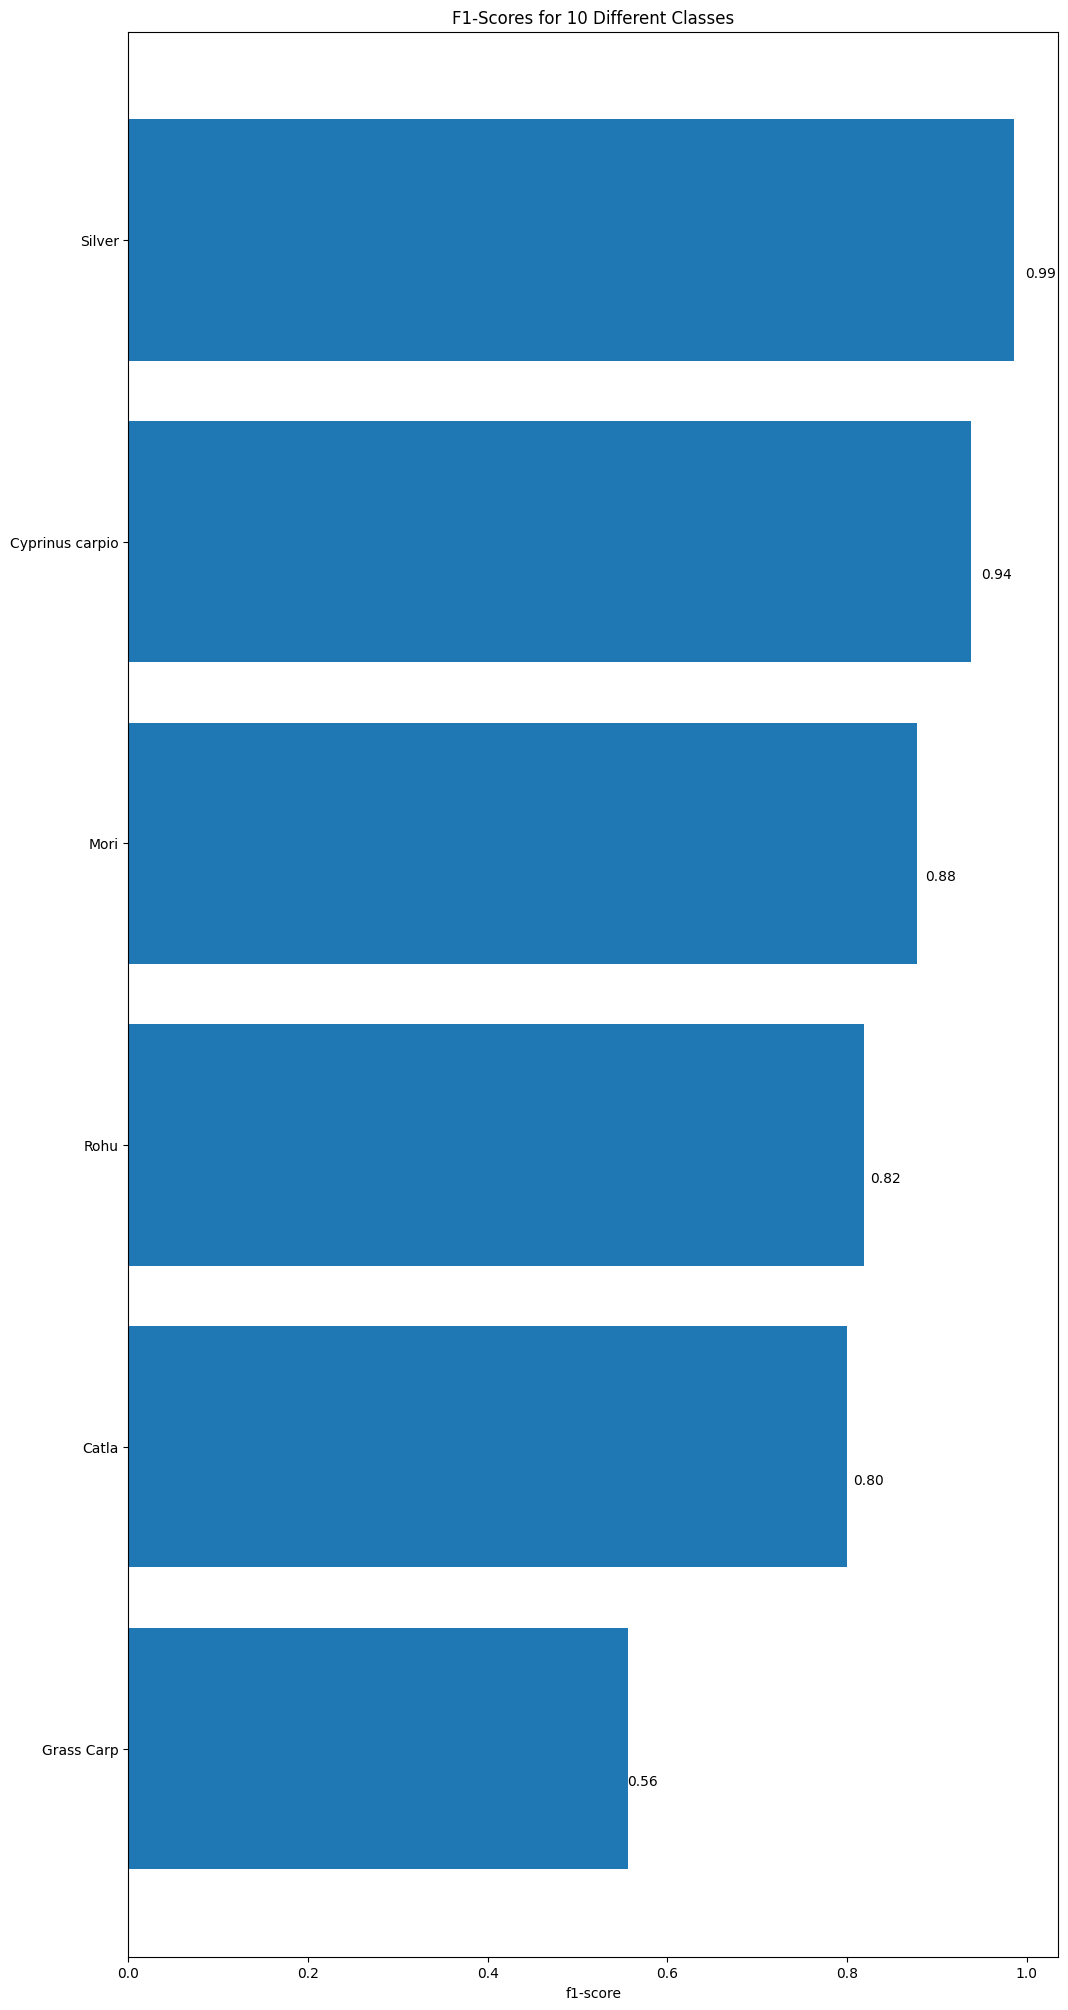

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [38]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 27ms/step


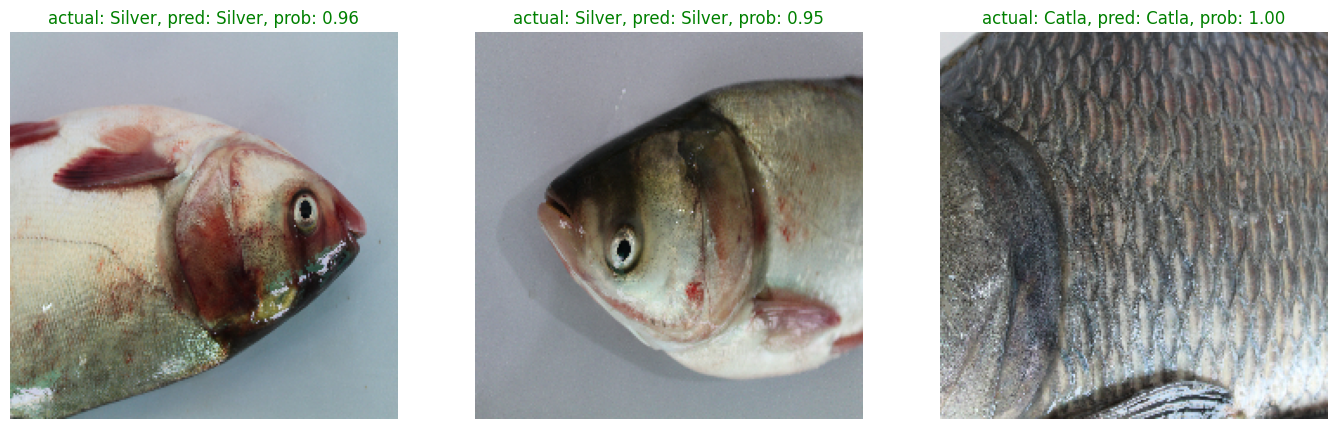

In [39]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

In [40]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/*/*.JPG",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (10).JPG',
 b'/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (11).JPG',
 b'/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (14).JPG',
 b'/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (15).JPG',
 b'/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (16).JPG',
 b'/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (17).JPG',
 b'/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (4).JPG',
 b'/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (5).JPG',
 b'/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (7).JPG',
 b'/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Head (16).JPG']

In [41]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       0   
1  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       0   
2  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       4   
3  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       4   
4  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       4   

   pred_conf y_true_classname y_pred_classname  
0   0.464799            Catla            Catla  
1   0.475010            Catla            Catla  
2   0.616104            Catla             Rohu  
3   0.651153            Catla             Rohu  
4   0.661351            Catla             Rohu

In [42]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       0   
1  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       0   
2  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       4   
3  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       4   
4  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       4   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.464799            Catla            Catla          True  
1   0.475010            Catla            Catla          True  
2   0.616104            Catla             Rohu         False  
3   0.651153            Catla             Rohu         False  
4   0.661351            Catla             Rohu         False

In [43]:
# 4. Get the top wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
4    b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       4   
3    b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       4   
2    b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       4   
21   b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       1       2   
118  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       4       1   
115  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       4       3   
63   b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       2       3   
136  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       4       3   
65   b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       2       3   
67   b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       2       1   
5    b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       4   
141  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       4       3   
14   b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       0       2   
61   b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       2       3   
46   b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       1       3   
128  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       4       1   
133  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       4       3   
57   b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       2       3   
134  b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       4       3   
62   b'/content/drive/MyDrive/Fish dataset/Fish_Spl...       2       3   

     pred_conf y_true_classname y_pred_classname  pred_correct  
4     0.661351            Catla             Rohu         False  
3     0.651153            Catla             Rohu         False  
2     0.616104            Catla             Rohu         False  
21    0.611896  Cyprinus carpio       Grass Carp         False  
118   0.582655             Rohu  Cyprinus carpio         False  
115   0.553382             Rohu             Mori         False  
63    0.500102       Grass Carp             Mori         False  
136   0.496239             Rohu             Mori         False  
65    0.493010       Grass Carp             Mori         False  
67    0.472995       Grass Carp  Cyprinus carpio         False  
5     0.464793            Catla             Rohu         False  
141   0.462010             Rohu             Mori         False  
14    0.445383            Catla       Grass Carp         False  
61    0.433249       Grass Carp             Mori         False  
46    0.414111  Cyprinus carpio             Mori         False  
128   0.394278             Rohu  Cyprinus carpio         False  
133   0.389114             Rohu             Mori         False  
57    0.378982       Grass Carp             Mori         False  
134   0.356461             Rohu             Mori         False  
62    0.310363       Grass Carp             Mori         False

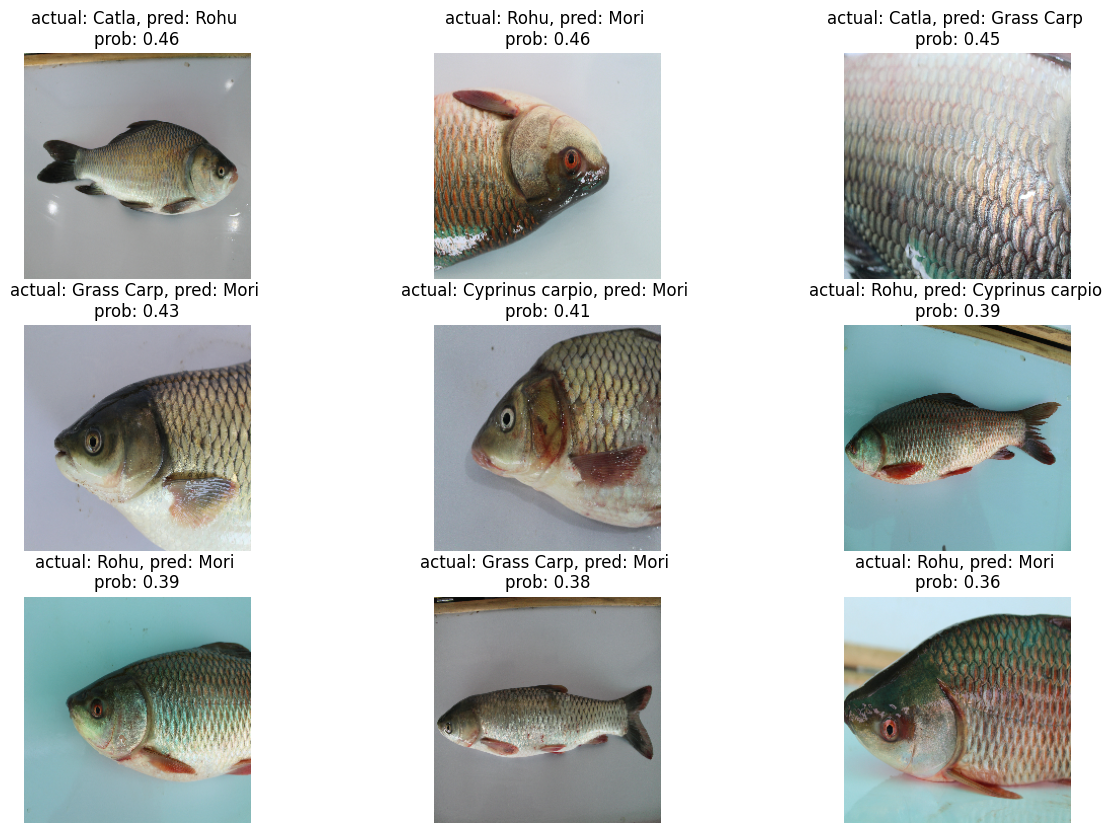

In [44]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [51]:
from google.colab import drive
import os


# Define the directory where your images are located in Google Drive
image_directory = "/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla"

# List all image file paths in the specified directory
custom_food_images = [os.path.join(image_directory, img_path) for img_path in os.listdir(image_directory)]

# Print the list of image file paths
print(custom_food_images)


['/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (5).JPG', '/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (7).JPG', '/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (11).JPG', '/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (10).JPG', '/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (15).JPG', '/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (14).JPG', '/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (16).JPG', '/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Body (17).JPG', '/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Head (5).JPG', '/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Head (8).JPG', '/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Head (16).JPG', '/content/drive/MyDrive/Fish dataset/Fish_Splitted/test/Catla/Catla-Head (25).J

1/1 [==============================] - 0s 25ms/step


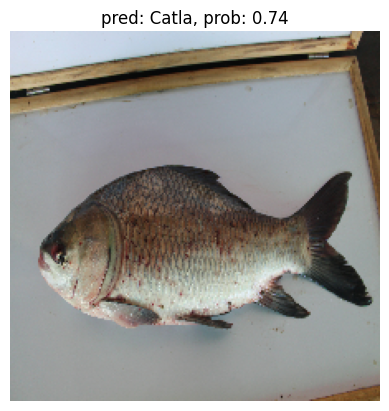

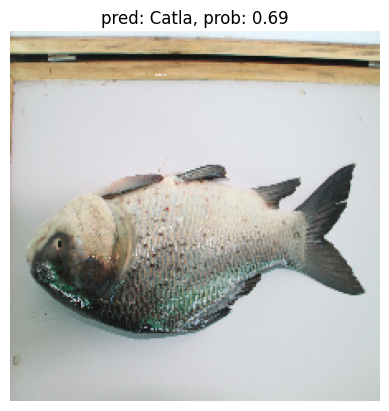

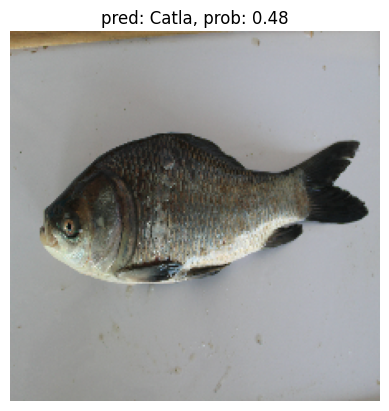

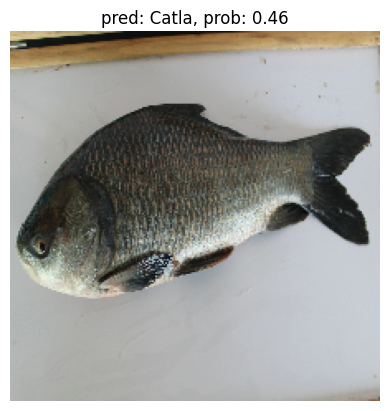

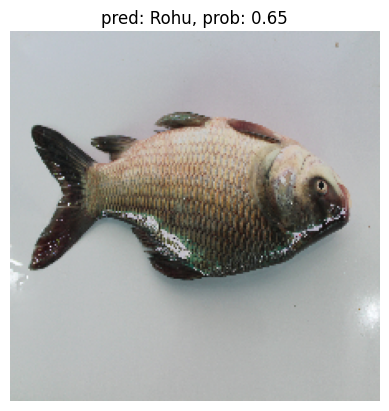

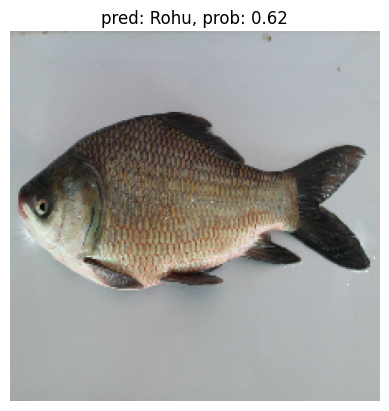

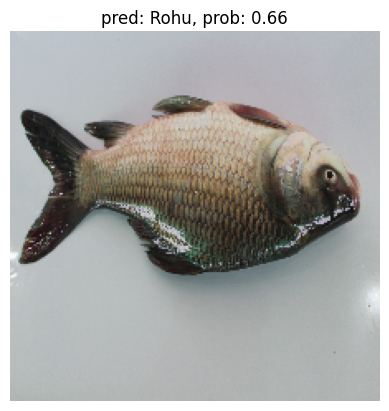

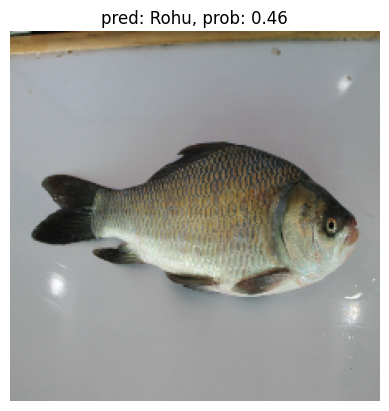

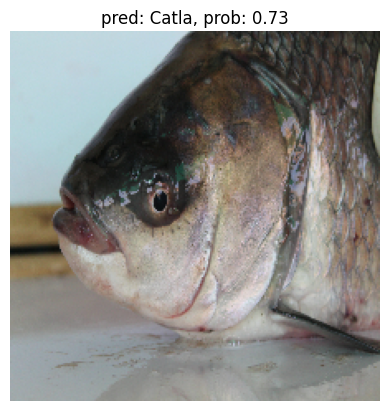

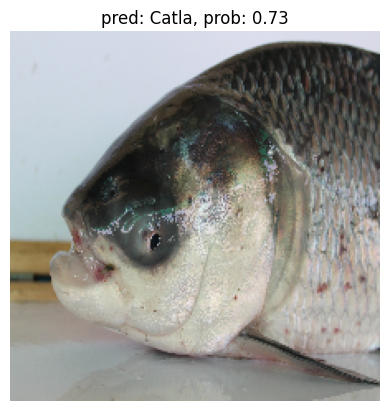

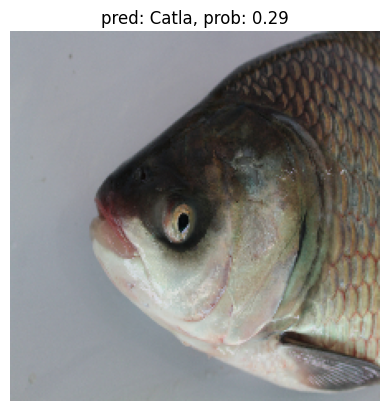

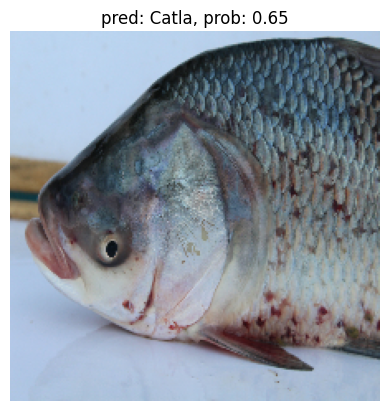

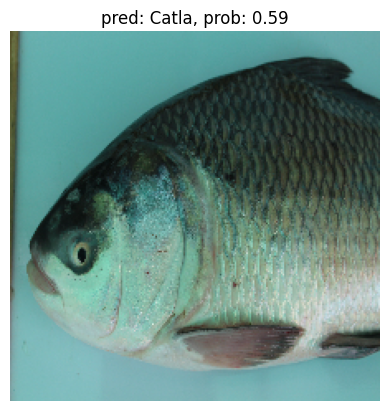

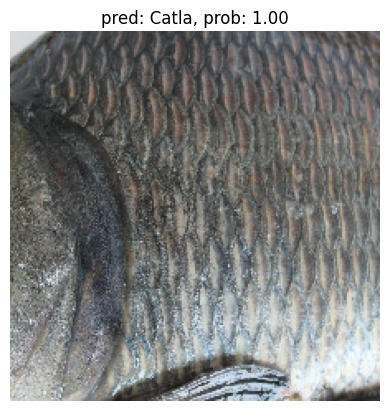

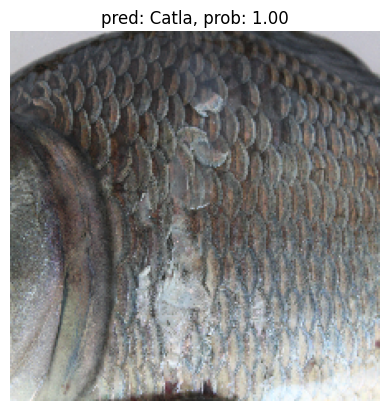

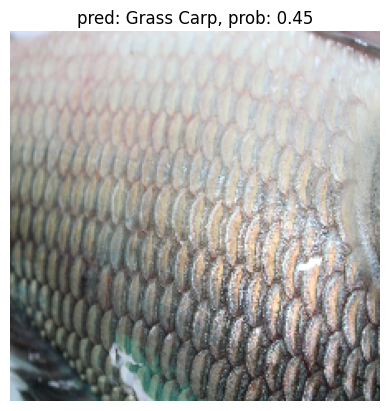

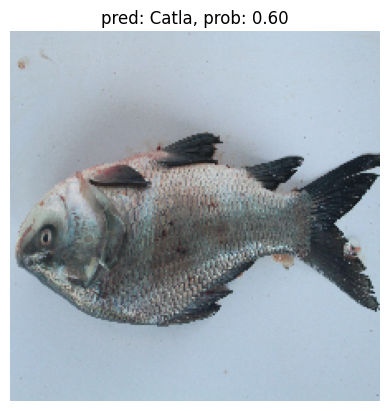

In [52]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)